In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
def integrator(x):
    y = np.zeros(np.size(x))
    for k in range(np.size(x)):
        y[k] = np.sum(x[:(k+1)])
    return y

def comb(x, D):
    y = np.append(x, np.zeros(D)) - np.append(np.zeros(D), x)
    return y[0:np.size(x)]


def cic_filter(x, R, N, cic_type):
    """CIC filter model

    Args:
    x (numpy.ndarray)	: Input array
               R(int)   : decimation / interpolation factor
               N(int)   : order
        cic_type(String): 'decim'  - decimator
                          'interp' - interpolator
                          
    Returns:
        y(numpy.ndarray): output array 
    """
    
    if (cic_type == 'decim'):
        
        x_z = np.zeros((N+1, np.size(x)))
        x_z[0, :] = x
        for k in range(1, N+1):
            x_z[k, :] = integrator(x_z[k - 1, :])
         
        # downsampling    
        if (R == 0):
            x_down = x_z[N, :]
        else:
            x_down = x_z[N, :np.size(x):R]
        
        x_z = np.zeros((N+1, np.size(x_down)))
        x_z[0, :] = x_down
        for k in range(1, N+1):
            x_z[k, :] = comb(x_z[k - 1, :], 2)
            
    if(cic_type == 'interp'):
        
        x_z = np.zeros((N+1, np.size(x)))
        x_z[0, :] = x
        for k in range(1, N+1):
            x_z[k, :] = comb(x_z[k - 1, :], 2)
            
        # upsampling 
        if (R == 0):
            x_up = x_z[N, :]
        else:
            x_up = np.zeros(np.size(x)*R)
            x_up[0:np.size(x)*R:R] = x_z[N, :]
        
        x_z = np.zeros((N+1, np.size(x_up)))
        x_z[0, :] = x_up
        for k in range(1, N+1):
            x_z[k, :] = integrator(x_z[k - 1, :])
         
    return  x_z[N, :]


def graficar_t(tiempo, senial_t, titulo, color = None):
    """
    Funcion que grafica una señal en funcion del tiempo.
    Entradas:
             tiempo: vector del eje del tiempo
             senial_t: vector que contiene la señal a graficar
             titulo: titulo de la grafica
    Salidas:
             Grafica la señal en funcion del tiempo.
    """
    if color is None: color = "b"
    else: color = color
    plt.plot(tiempo, senial_t, color, label = titulo)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend()

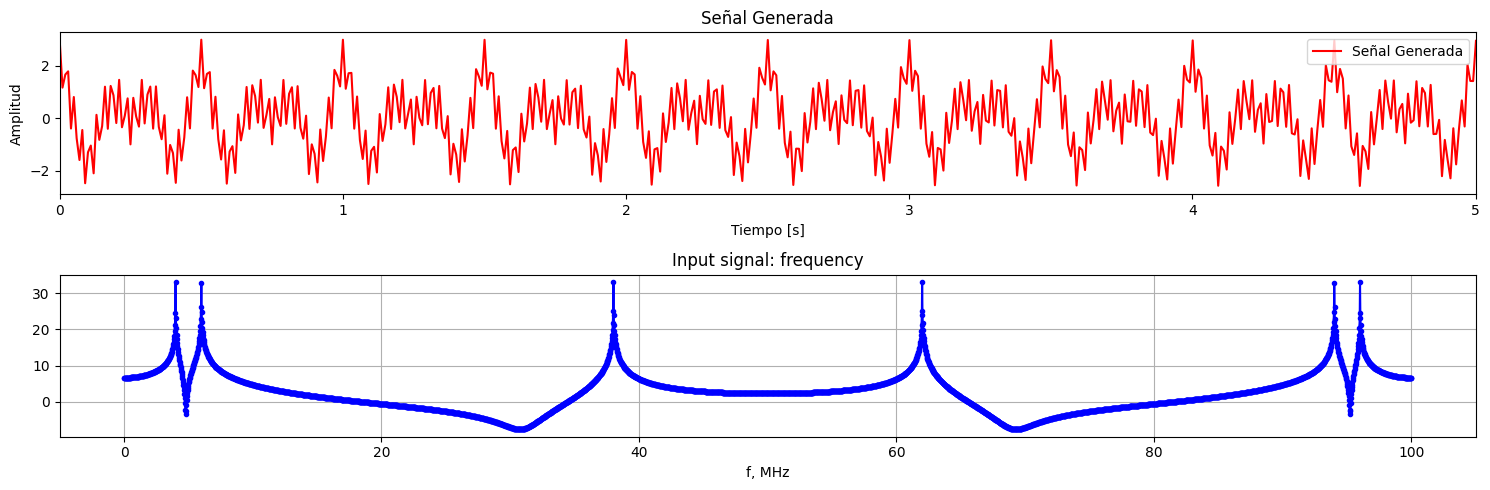

In [57]:
plt.close('all')

cic_order = 4
R_Factor  = 4

N   = 4096 
Fs  = 100e6
t   = np.linspace(0, N/Fs, N)
f   = np.linspace(0, Fs, N)
fnew= np.linspace(0, Fs/R_Factor, round(N/R_Factor))
x   = np.cos(2*np.pi*4e6*t)
x  += np.cos(2*np.pi*6e6*t)
x  += np.cos(2*np.pi*38e6*t)

x_16 = np.round((2**15 - 16)*(x/np.max(x)))
np.savetxt('files/cic_dec_input.txt', x_16, fmt='%d')


plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.title("Señal Generada")
graficar_t(t/1e-6,x,"Señal Generada",'r')
plt.axis([0,5,None,None])


# ESPECTRO
XF  = np.fft.fft(x, n=N, axis=0, norm=None)
plt.subplot(212)
plt.plot(f/1e6, 10*np.log10(np.abs(XF)), '.-b')
plt.xlabel('f, MHz')
plt.title('Input signal: frequency')
plt.grid()
plt.tight_layout()

plt.show()

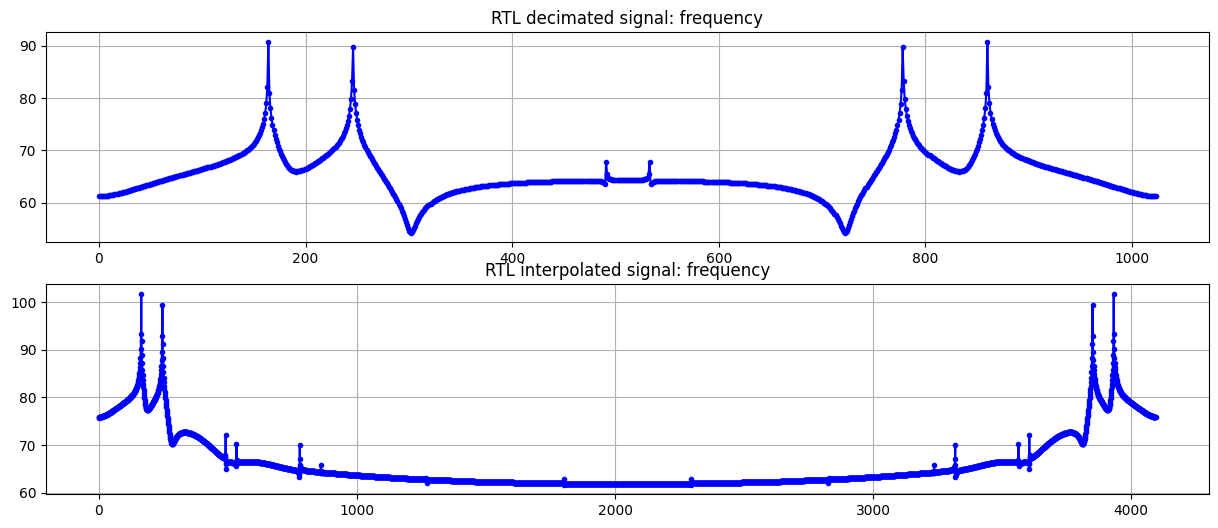

In [58]:
# DATOS OBTENIDOS EN VIVADO

rtl_dec  = np.loadtxt('files/cic_dec.txt')
rtlF_dec = np.fft.fft(rtl_dec)

rtl_int  = np.loadtxt('files/cic_int.txt')
rtlF_int = np.fft.fft(rtl_int)

plt.figure(figsize=(15, 6))

plt.subplot(211)
plt.plot(10*np.log10(np.abs(rtlF_dec)), '.-b')
plt.title('RTL decimated signal: frequency')
plt.grid()

plt.subplot(212)
plt.plot(10*np.log10(np.abs(rtlF_int)), '.-b')
plt.title('RTL interpolated signal: frequency')
plt.grid()
plt.show()

Decimation
Interpolation


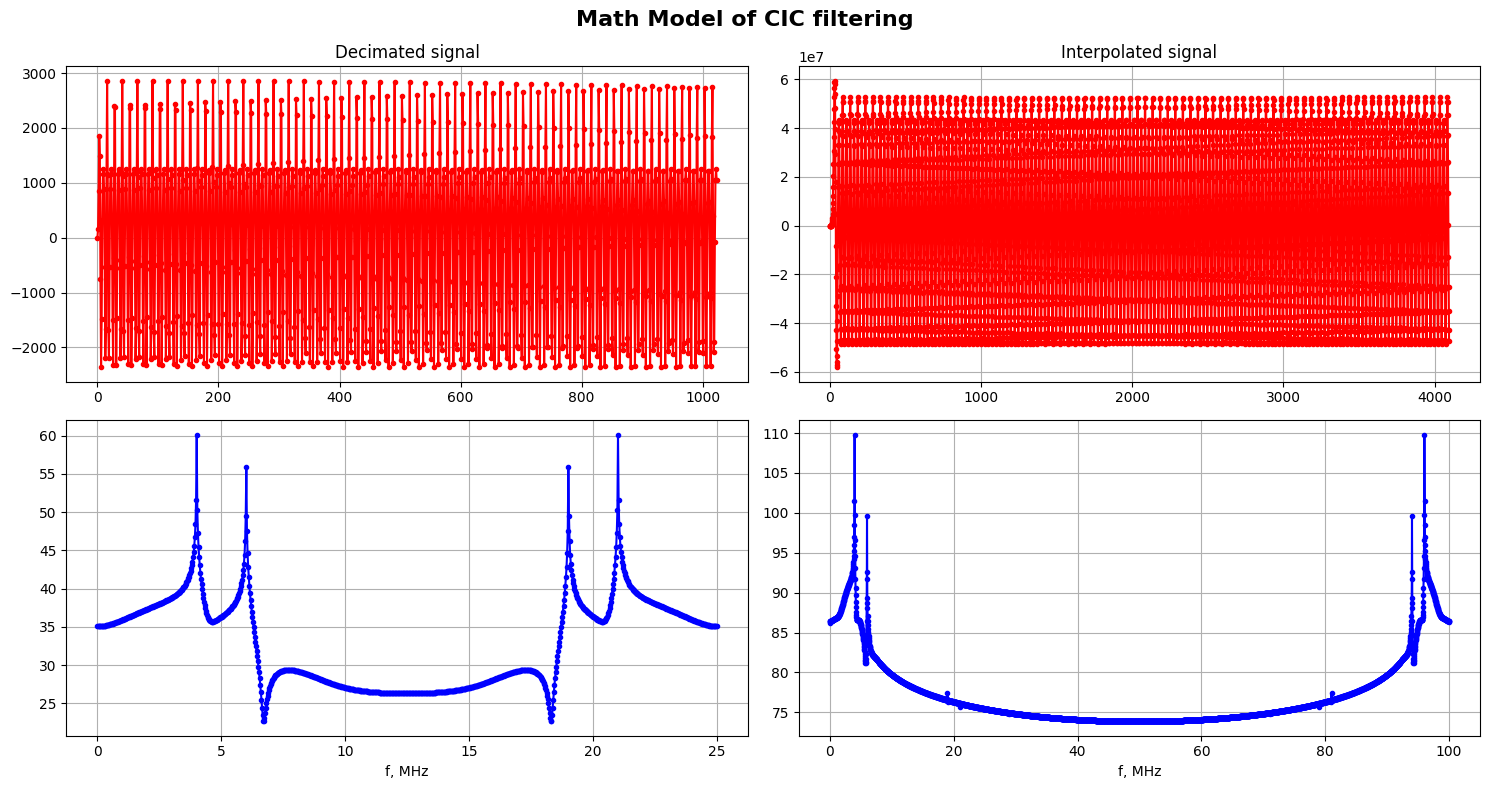

In [59]:
print('Decimation')
y   = cic_filter(x, R_Factor, cic_order, 'decim')
YF  = np.fft.fft(y, n=round(N/R_Factor), axis=0, norm=None)
plt.figure(figsize=(15, 8))
plt.suptitle("Math Model of CIC filtering",fontsize=16,fontweight='bold')
plt.subplot(221)
plt.plot(y, '.-r')
plt.grid()
plt.title('Decimated signal')
plt.subplot(223)
plt.plot(fnew/1e6, 10*np.log10(np.abs(YF)), '.-b')
plt.xlabel('f, MHz')
plt.grid()

cic_order = 6

print('Interpolation')
z   = cic_filter(y, R_Factor, cic_order, 'interp')
ZF  = np.fft.fft(z)



plt.subplot(222)
plt.plot(z, '.-r')
plt.grid()
plt.title('Interpolated signal')
plt.subplot(224)
plt.plot(f/1e6, 10*np.log10(np.abs(ZF)), '.-b')
plt.xlabel('f, MHz')
plt.grid()
plt.tight_layout()

plt.show()